# Data Analysis of Network Traffic

## Imports and Dependencies

In [37]:
!pip install xgboost

You should consider upgrading via the '/Users/abdulnaser/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [130]:
from datetime import datetime
import numpy as np
import pandas as pd
import statistics
import csv
 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,KFold
import xgboost as xgb

## Overview of the data

In [173]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df= pd.read_csv("dataset.csv")
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [174]:
print("dataset has the shape : {} ".format(df.shape) )
print("{} rows and {} columns  \n\n".format(df.shape[0],df.shape[1] ) )

dataset has the shape : (4968, 15) 
4968 rows and 15 columns  




In [172]:
df.head()

,Unnamed: 0,frame_time_epoch,frame_len,eth_src,device_name_src,eth_dst,device_name_dst,eth_type,ip_src,srcport,ip_dst,dstport,ip_proto,payload_utf8,action,attack
0,0,1.674747e+09,66,04:CF:4B:3B:00:58,NaN,0E:F2:26:7D:04:1A,NaN,0x0800,18.196.142.136,8883.0,192.168.12.148,38462.0,6.0,NaN,NaN,NaN
1,1,1.674747e+09,303,A8:03:2A:B1:35:60,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.80,51705.0,34.140.193.14,6022.0,6.0,,NaN,NaN
2,2,1.674747e+09,66,0E:F2:26:7D:04:1A,NaN,04:CF:4B:3B:00:58,NaN,0x0800,192.168.12.148,38462.0,18.196.142.136,8883.0,6.0,NaN,NaN,NaN
3,3,1.674747e+09,54,04:CF:4B:3B:00:58,NaN,A8:03:2A:B1:35:60,NaN,0x0800,34.140.193.14,6022.0,192.168.12.80,51705.0,6.0,NaN,NaN,NaN
4,4,1.674747e+09,128,0E:F2:26:7D:04:1A,NaN,FF:FF:FF:FF:FF:FF,NaN,0x0800,192.168.12.148,52149.0,255.255.255.255,7000.0,17.0,NaN,NaN,NaN


In [136]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)
df_cat = df.select_dtypes(include="object")
print("The dataset has {} numerical features and {} Categorigcal features ".format( len(df_num.columns), len(df_cat.columns)  ) )


The dataset has 6 numerical features and 10 Categorigcal features 


In [137]:
df_num.columns

Index(['Unnamed: 0', 'frame_time_epoch', 'frame_len', 'srcport', 'dstport', 'ip_proto'], dtype='object')

In [138]:
df_cat.columns

Index(['eth_src', 'device_name_src', 'eth_dst', 'device_name_dst', 'eth_type', 'ip_src', 'ip_dst', 'payload_utf8', 'action', 'attack'], dtype='object')

## Missing data

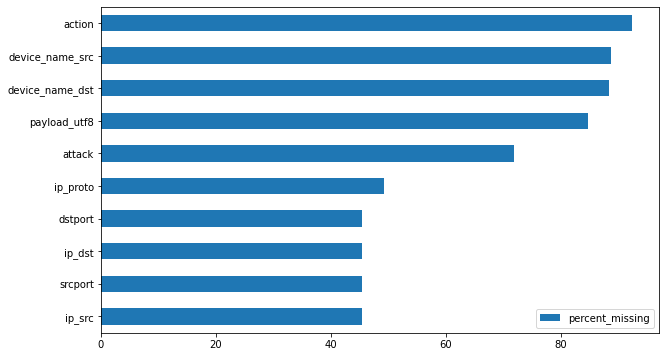

In [139]:
( df.isnull().sum() * 100 / len(df) ).to_frame(name='percent_missing').query('percent_missing>0').sort_values(by='percent_missing', ascending=True).plot.barh( figsize=(10,6));

<AxesSubplot:title={'center':'Percent for each attack type'}>

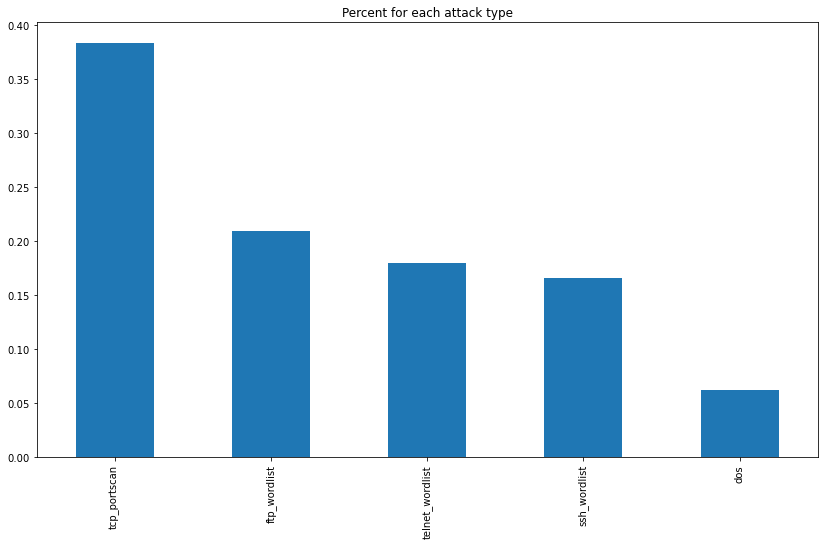

In [140]:
df.attack.value_counts(normalize=True).plot(kind='bar' , figsize=(14,8),
                                    title="Percent for each attack type")

## Binary classification

In [141]:
# Remove unnecessary columns
columns_to_remove = ['frame_time_epoch','eth_src','device_name_src','eth_dst','device_name_dst','ip_src',
                    'ip_dst','payload_utf8','action']

df.drop(columns_to_remove, axis=1, inplace=True)

In [142]:
df.head()

,Unnamed: 0,frame_len,eth_type,srcport,dstport,ip_proto,attack
0,0,66,0x0800,8883.0,38462.0,6.0,NaN
1,1,303,0x0800,51705.0,6022.0,6.0,NaN
2,2,66,0x0800,38462.0,8883.0,6.0,NaN
3,3,54,0x0800,6022.0,51705.0,6.0,NaN
4,4,128,0x0800,52149.0,7000.0,17.0,NaN


In [143]:
# Convert the attack column into binary column 
df['attack'] = df['attack'].fillna(0)
df['attack'] = np.where(df['attack'] != 0, 1, df['attack'])
df['attack'] = df['attack'].astype(int)

<AxesSubplot:title={'center':'Percent for each attack type'}>

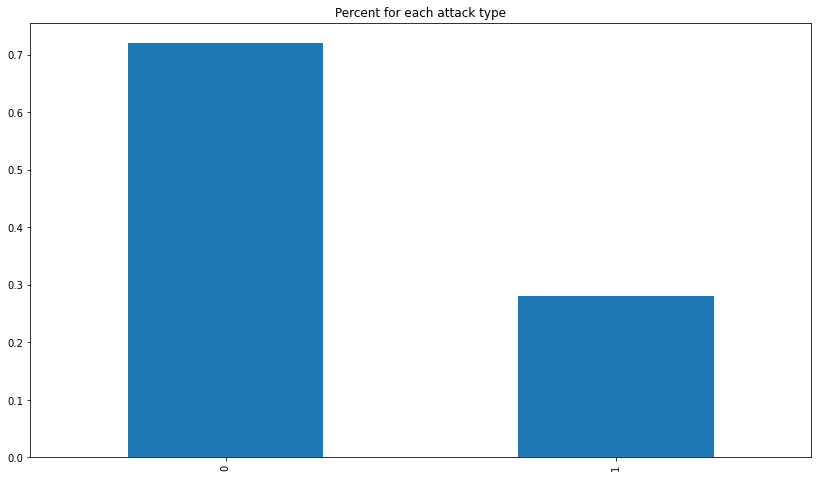

In [144]:
df.attack.value_counts(normalize=True).plot(kind='bar' , figsize=(14,8),
                                    title="Percent for each attack type")

In [145]:
df.attack.value_counts()

0    3575
1    1393
Name: attack, dtype: int64

In [146]:
df.shape

(4968, 7)

In [147]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_num = df.select_dtypes(include=numerics)
df_cat = df.select_dtypes(include="object")
print("The dataset has {} numerical features and {} Categorigcal features ".format( len(df_num.columns), len(df_cat.columns)  ) )


The dataset has 6 numerical features and 1 Categorigcal features 


In [55]:
df_num.columns

Index(['frame_len', 'srcport', 'dstport', 'ip_proto', 'attack'], dtype='object')

In [56]:
df_cat.columns

Index(['Unnamed: 0', 'eth_type'], dtype='object')

In [148]:
df["eth_type"].unique()

array(['0x0800', '0x0806'], dtype=object)

In [149]:
# Get one hot encoding of columns eth_type
one_hot = pd.get_dummies(df['eth_type'])
# Drop column eth_type as it is now encoded
df = df.drop('eth_type',axis = 1)
# Join the encoded df
df = df.join(one_hot)
df.head()

,Unnamed: 0,frame_len,srcport,dstport,ip_proto,attack,0x0800,0x0806
0,0,66,8883.0,38462.0,6.0,0,1,0
1,1,303,51705.0,6022.0,6.0,0,1,0
2,2,66,38462.0,8883.0,6.0,0,1,0
3,3,54,6022.0,51705.0,6.0,0,1,0
4,4,128,52149.0,7000.0,17.0,0,1,0


In [150]:
df['ip_proto'].unique()

array([ 6., 17., nan])

In [60]:
#'0x0800','0x0806'

In [151]:
X = df[['frame_len','srcport','dstport','ip_proto','0x0806']]
Y = df[['attack']]

In [62]:
Y.head()

,attack
0,0
1,0
2,0
3,0
4,0


In [152]:
# XGBoost (different learning rate)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=65)
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
lernrate = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(x_train, y_train)
    lernrate.append(lr)
    train_XG.append(xgb_classifier.score(x_train, y_train))
    test_XG.append(xgb_classifier.score(x_test, y_test)) 

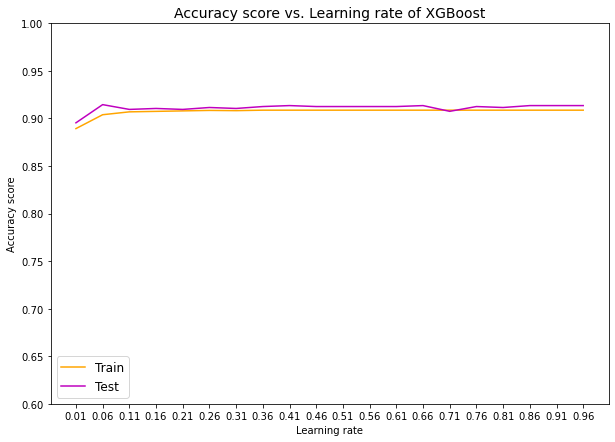

In [153]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.plot(learning_rate_range, train_XG, c='orange', label='Train')
ax.plot(learning_rate_range, test_XG, c='m', label='Test')
ax.set_xlabel('Learning rate')
ax.set_xticks(learning_rate_range)
ax.set_ylabel('Accuracy score')
ax.set_ylim(0.6, 1)
ax.legend(prop={'size': 12}, loc=3)
ax.set_title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

### Training with cross validation 

In [154]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Define the XGBoost model
model = xgb.XGBClassifier()

# Define the cross-validation scheme
kfold = KFold(n_splits=10)

# Train the model using cross-validation
results = []
for train_index, test_index in kfold.split(X_train):
    model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_pred = model.predict(X_train.iloc[test_index])
    accuracy = accuracy_score(y_train.iloc[test_index], y_pred)
    results.append(accuracy)

mean_accuracy = statistics.mean(results)
print("Mean accuracy: %.2f%% (%.2f%%)" % (mean_accuracy * 100, statistics.stdev(results) * 100))


# Train the model on the full training data
model.fit(X_train, y_train)


importance = model.get_booster().get_score(importance_type="weight")
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features = [item[0] for item in importance]
print(importance)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Print the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.2f%%" % (accuracy * 100.0))

Mean accuracy: 90.46% (1.26%)
[('frame_len', 520.0), ('srcport', 382.0), ('dstport', 352.0), ('ip_proto', 22.0)]
Test Accuracy: 90.95%


## Analysing the correlation bewtween the predictors and the "Attack" variable 

To make sure that the results delieverd by the classification model can be trusted, the correlation between the predictors and the reponse variable "Attack" was investigated.

1) The correlation between frame_len and attack

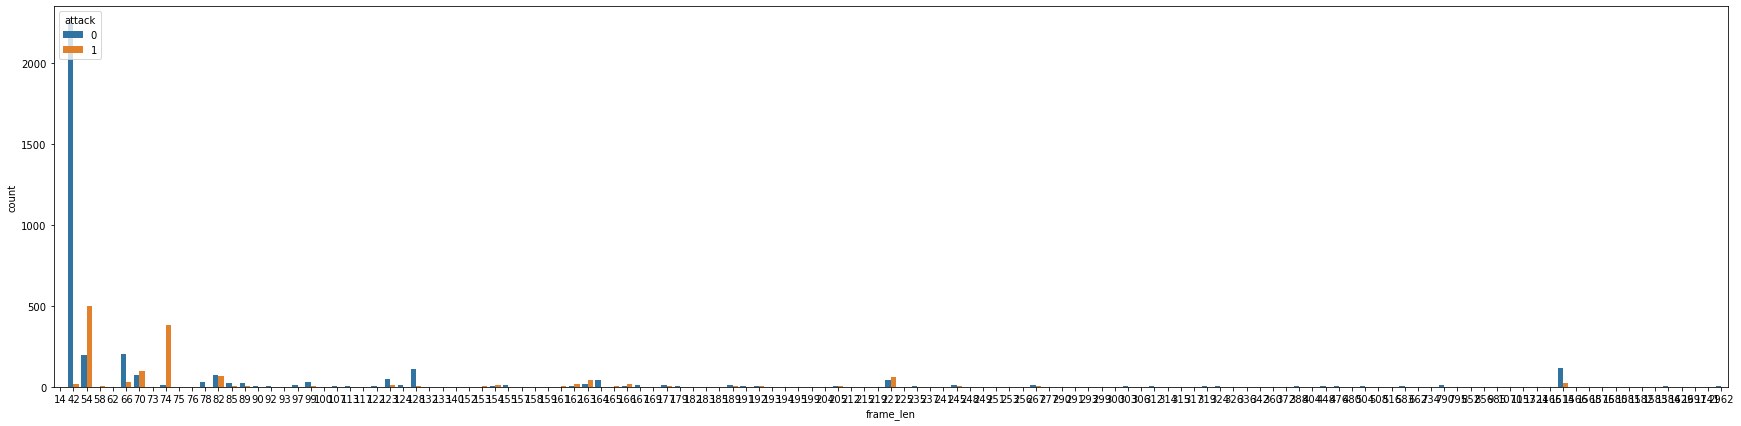

In [155]:
plt.figure(figsize=(30, 7))
sns.countplot(x='frame_len', hue='attack', data=df)
plt.show()

It can be observed that around 900 of the 1393 attack cases that happend, the frame length was either 54 or 74 and in more than 2500 cases , where there were no attacks , the frames had the length of 42 ,
which indicates
that this feature may play an important role in the classification task.

2) The correlation between srcport and attack

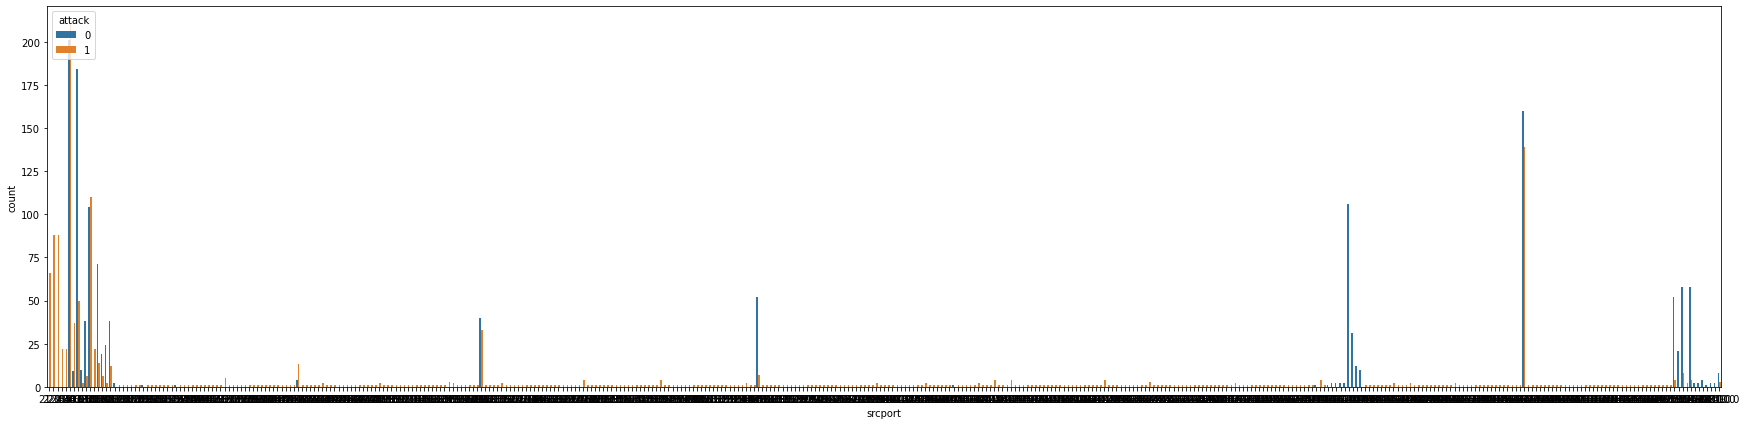

In [156]:
plt.figure(figsize=(30, 7))
sns.countplot(x='srcport', hue='attack', data=df)
plt.show()

The port numbers of the source devices play also an important role, when it comes to classification. It can be noticed 
in the far left of the graph that by some port numbers the number of attack cases is very high. Additionally , it can also
be noticed on the right side that by some port numbers the number of attack cases is very low. 




3) The correlation between Ethertype and attack

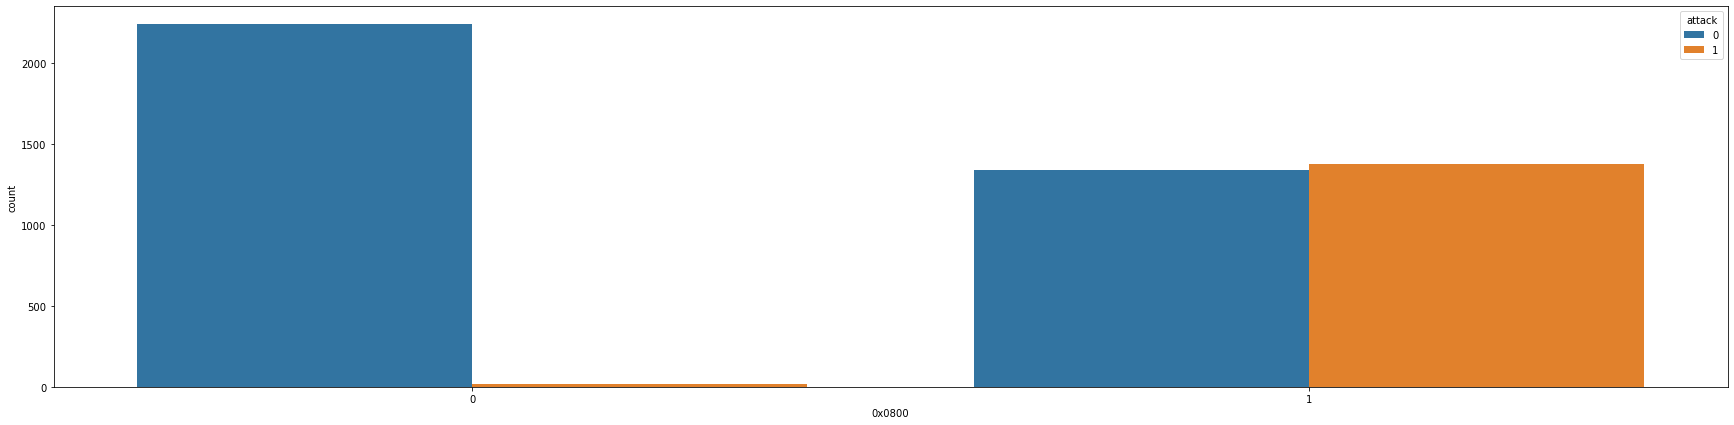

In [157]:
plt.figure(figsize=(30, 7))
sns.countplot(x='0x0800', hue='attack', data=df)
plt.show()

It can be noticed that the IPv4 ethertype has not any predictive power. Moreover, it can reduce the predication accuracy. 

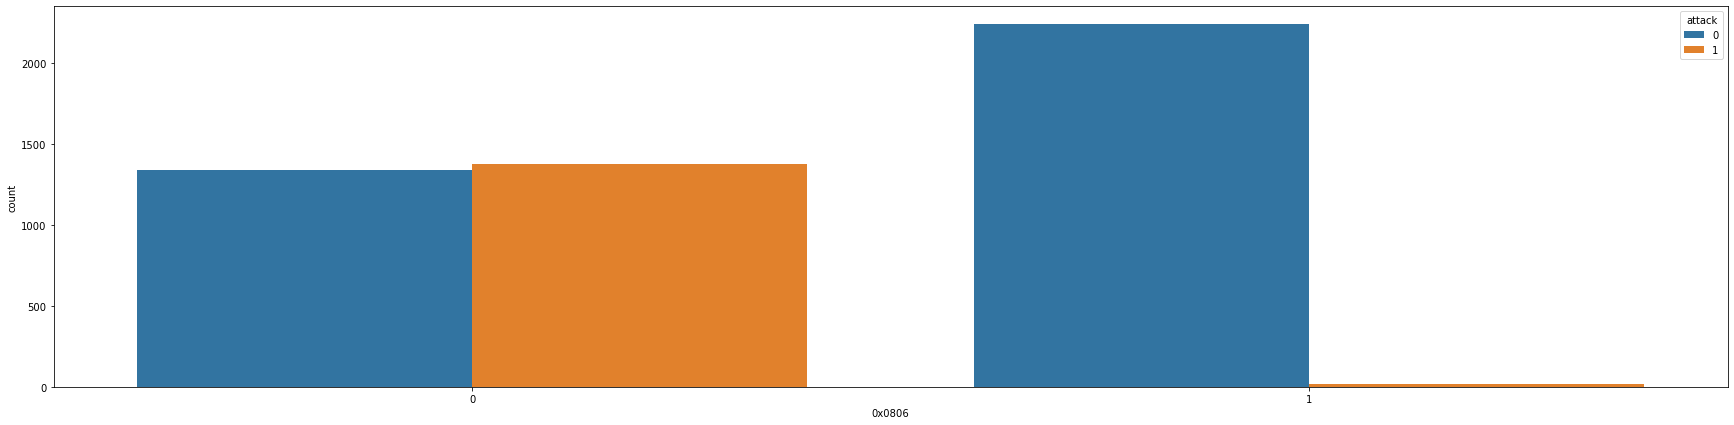

In [158]:
plt.figure(figsize=(30, 7))
sns.countplot(x='0x0806', hue='attack', data=df)
plt.show()

The ARP ethernet type has good predictive power , as it refers in most times that there is no attack 